In [4]:
# Učitavanje modula
import os
import numpy as np
import matplotlib.pyplot as plt
from obspy.signal import PPSD
from obspy.imaging.cm import pqlx
from obspy import read, read_inventory
from obspy.signal.invsim import paz_to_freq_resp

# Namjestite put do foldera u kojem su podatci
data_folder = "./DN_DATA/"
responses_folder = "./Responses/"

         network: DN
         station: DF06
        location: 
         channel: HHE
       starttime: 2023-03-23T00:00:00.000000Z
         endtime: 2023-03-23T23:59:59.990000Z
   sampling_rate: 100.0
           delta: 0.01
            npts: 8640000
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'D', 'number_of_records': 20993, 'encoding': 'STEIM1', 'byteorder': '>', 'record_length': 512, 'filesize': 10748416})


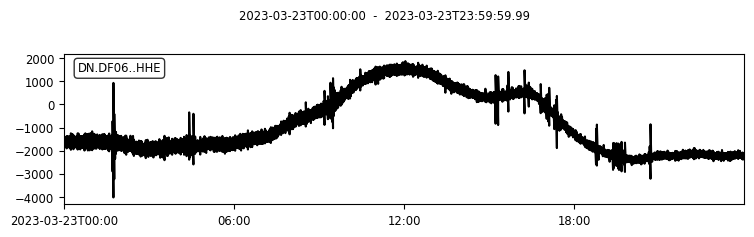

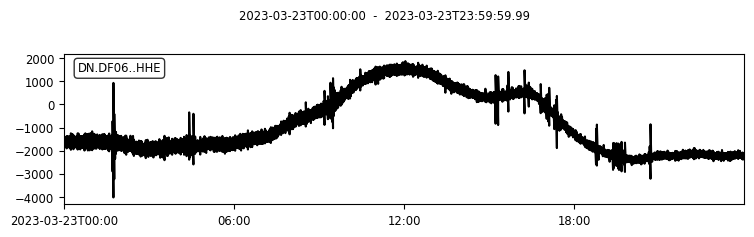

In [24]:
# Učitavanje podataka
st = read(os.path.join(data_folder,"DN.DF06..HHE*"),format='MSEED')

# Ispis osnovnih info o podatcima
print(st[0].stats)

# Crtanje podataka
st.plot()

In [12]:
# Učitavanje XML datoteke koja sadrži instrumentalni odziv
inv_xml = read_inventory(os.path.join(responses_folder,"./DN.DF06.xml"))

# Učitvanje RESP datoteka koje sadrže informacije o instrumentalnom odziva
inv_resp = read_inventory(os.path.join(responses_folder,"./DN.DF06.HHE*"))

# Definiranje filtra koji se koristi prilikom micanja instrumentalnog odziva
pre_filt = [1/120, 1/115, 46, 48]

1 Trace(s) in Stream:
DN.DF06..HHE | 2023-03-23T00:00:00.000000Z - 2023-03-23T23:59:59.990000Z | 100.0 Hz, 8640000 samples

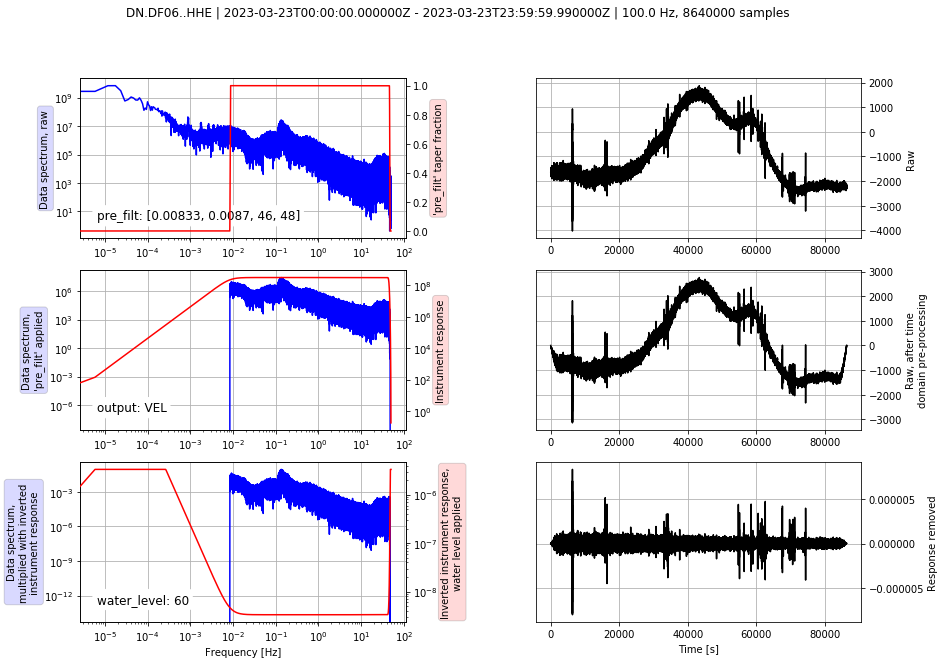

In [25]:
# Micanje instrumentalnog odziva pomoću XML datoteke
st1 = st.copy()
st1.remove_response(inventory=inv_xml, pre_filt=pre_filt, output="VEL", plot=True)

1 Trace(s) in Stream:
DN.DF06..HHE | 2023-03-23T00:00:00.000000Z - 2023-03-23T23:59:59.990000Z | 100.0 Hz, 8640000 samples

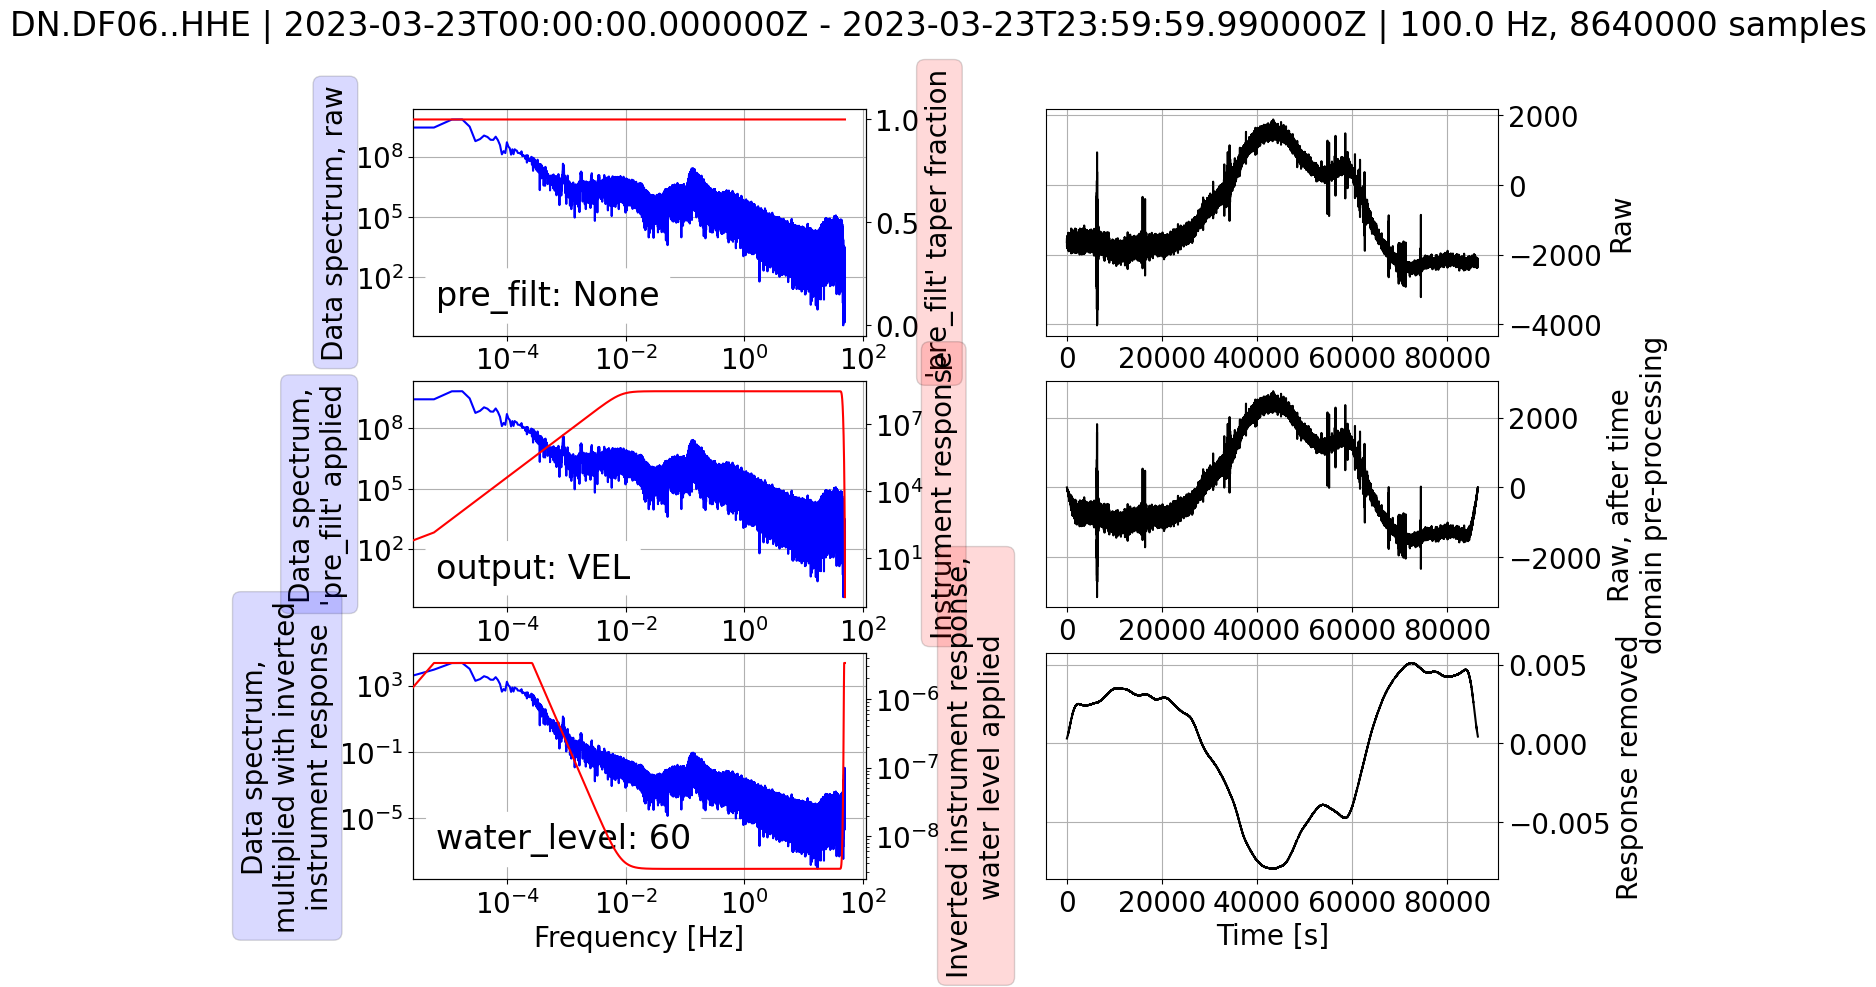

In [9]:
# Micanje instrumentalnog odgovora pomoću RESP datoteka
st2 = st.copy()
st2.remove_response(inventory=inv_resp, pre_filt=pre_filt, output="VEL", plot=True)
#st2.remove_response(inventory=inv_xml, pre_filt=None, output="VEL", plot=True)

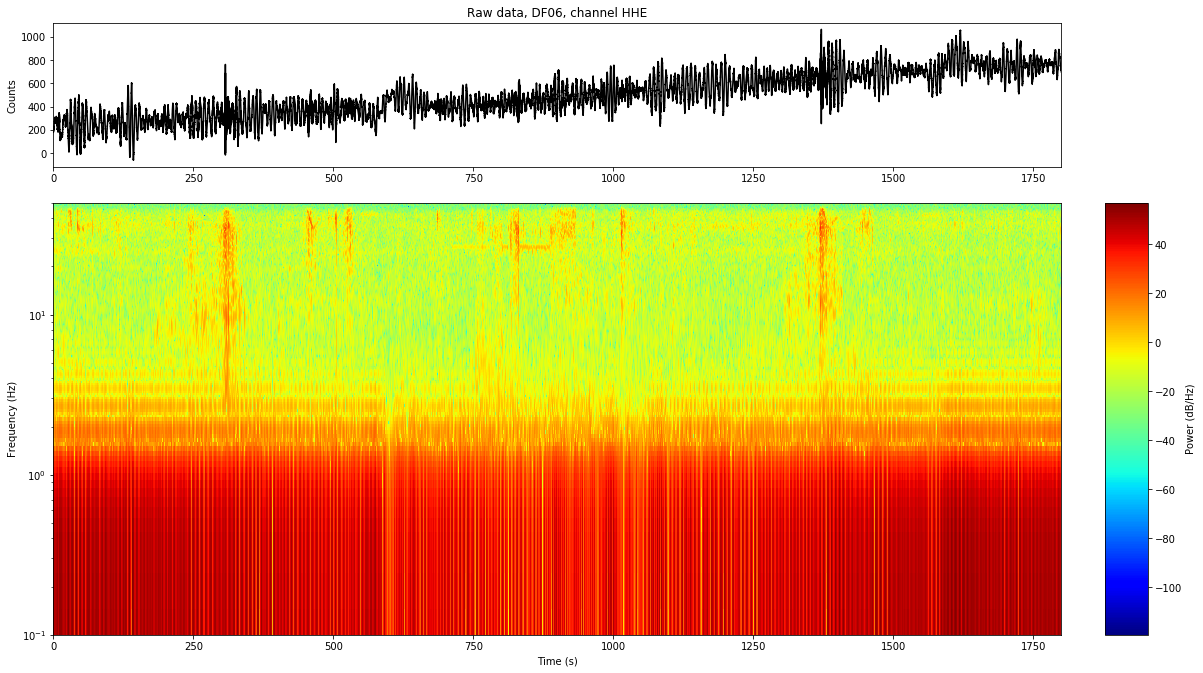

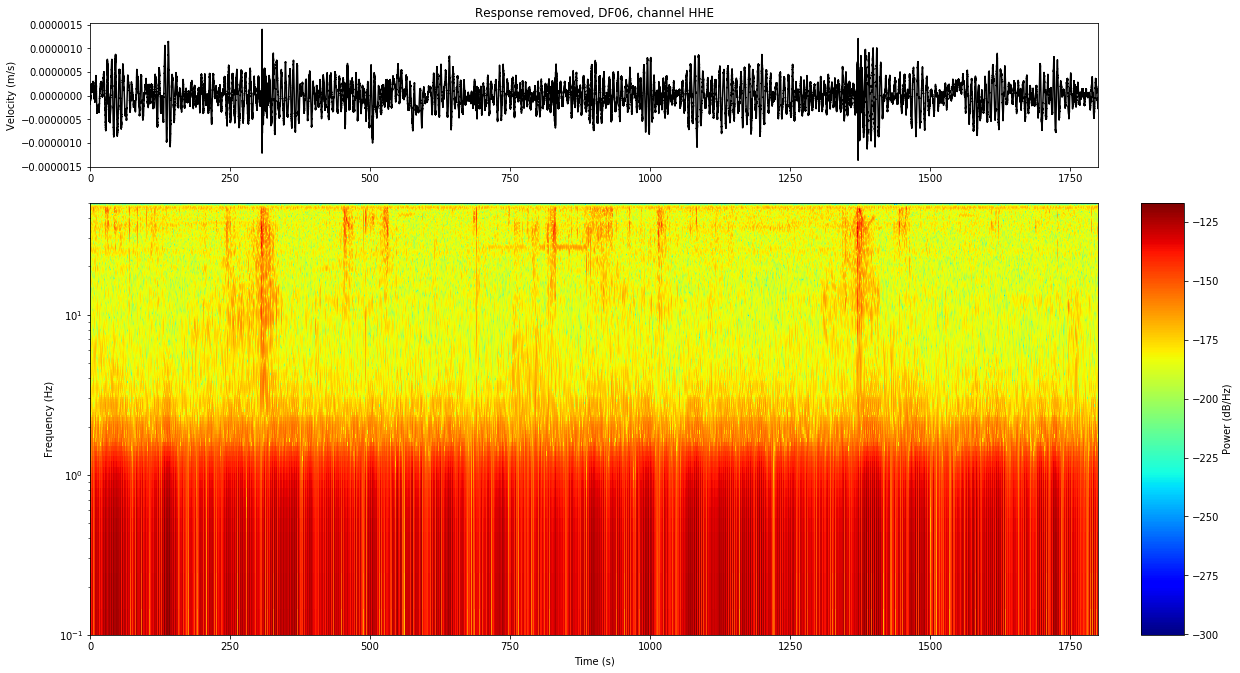

In [26]:
# Crtamo seizmograme i njihove spektrograme
t1 = st[0].stats.starttime + 35000
win_len = 1800 # duljina vremenskog prozora u s
t2 = t1 + win_len

# Seizmogram prije micanja instrumentalnog odziva
tr = st[0].trim(t1,t2)
t = np.arange(tr.stats.npts) / tr.stats.sampling_rate
sps = st[0].stats.sampling_rate

fig = plt.figure(figsize=(20,10))
ax1 = fig.add_axes([0.1, 0.75, 0.7, 0.2])
ax2 = fig.add_axes([0.1, 0.1, 0.7, 0.60], sharex=ax1)
ax3 = fig.add_axes([0.83, 0.1, 0.03, 0.6])

ax1.plot(t, tr.copy().data, 'k')
ax1.title.set_text("Raw data, "+ tr.stats.station+ ", channel "+ tr.stats.channel)
ax1.set_ylabel('Counts')

tr.spectrogram(per_lap=0.95, dbscale=True, log=True, axes=ax2, cmap='jet')
ax2.set_ylim((0.1,sps/2))
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Frequency (Hz)')

mappable = ax2.collections[0]
cb = plt.colorbar(mappable=mappable, cax=ax3)
cb.set_label('Power (dB/Hz)')
    
# Seizmogram nakon micanja instrumentalnog odziva
tr1 = st1[0].trim(t1,t2)
t11 = np.arange(tr1.stats.npts) / tr1.stats.sampling_rate
sps1 = st1[0].stats.sampling_rate
    
fig1 = plt.figure(figsize=(20,10))
ax4 = fig1.add_axes([0.1, 0.75, 0.7, 0.2])
ax5 = fig1.add_axes([0.1, 0.1, 0.7, 0.60], sharex=ax4)
ax6 = fig1.add_axes([0.83, 0.1, 0.03, 0.6])

ax4.plot(t11, tr1.copy().data, 'k')
ax4.title.set_text("Response removed, "+tr1.stats.station+ ", channel "+ tr1.stats.channel)
ax4.set_ylabel('Velocity (m/s)')

tr1.spectrogram(per_lap=0.95, dbscale=True, log=True, axes=ax5, cmap='jet')
ax5.set_ylim((0.1,sps1/2))
ax5.set_xlabel('Time (s)')
ax5.set_ylabel('Frequency (Hz)')

mappable = ax5.collections[0]
cb = plt.colorbar(mappable=mappable, cax=ax6)
cb.set_label('Power (dB/Hz)')

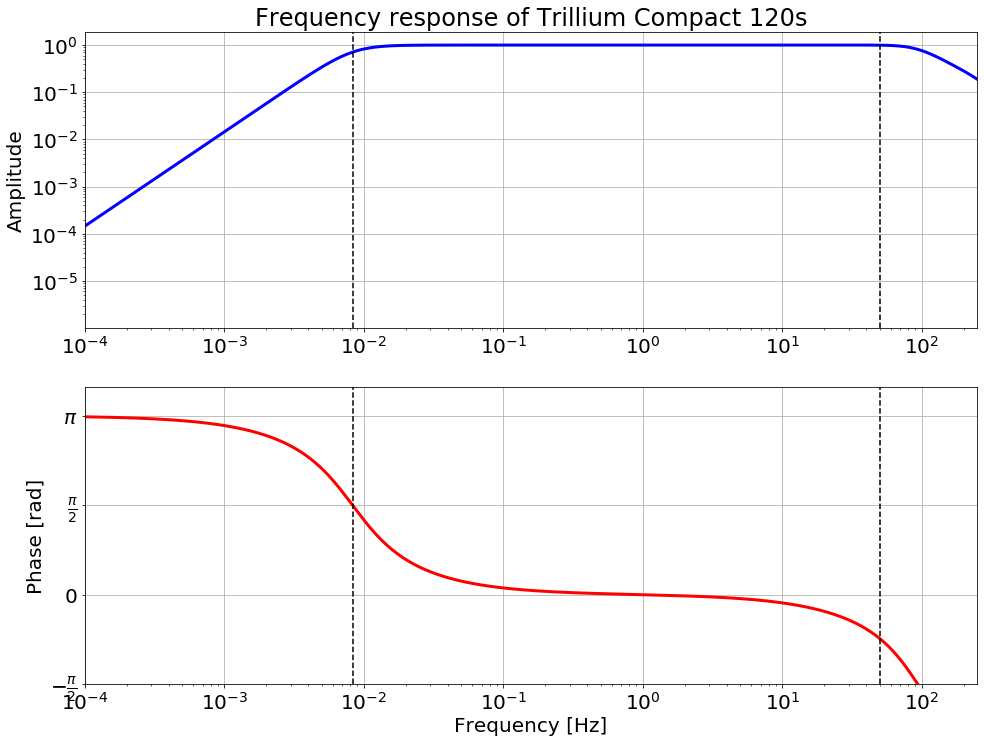

In [40]:
# Crtanje instrumentalnih odziva
for net in inv_xml.networks:
    for sta in net.stations:
        for cha in sta.channels:
            seed_id = "%s.%s.%s.%s" % (net.code, sta.code,cha.location_code,cha.code)
            resp = inv_xml.get_response(seed_id,cha.start_date + 10)
            polezerostage = resp.get_paz()
            poles = polezerostage.poles
            zeros = polezerostage.zeros
            gain = polezerostage.normalization_factor

            h, f = paz_to_freq_resp(poles, zeros, gain, 1/500, 8640000*5,freq=True)
            
            if cha.code == st[0].stats.channel:
                fig = plt.figure(figsize=(16, 12))
                plt.rcParams.update({'font.size': 20})
                plt.subplot(211)
                plt.grid()
                plt.title('Frequency response of Trillium Compact 120s')
                plt.loglog(f, abs(h),lw=3,c='b')
                plt.axvline(x=tr.stats.sampling_rate/2,color="k",ls="--")
                plt.axvline(x=1/120,color="k",ls="--")
                plt.xlim(0.0001, 250)
                plt.ylabel('Amplitude')

                plt.subplot(212)
                plt.grid()
                phase = np.unwrap(np.angle(h))
                plt.semilogx(f, phase,lw=3,c='r')
                plt.axvline(x=tr.stats.sampling_rate/2,color="k",ls="--")
                plt.axvline(x=1/120,color="k",ls="--")
                plt.yticks(
                    [-np.pi/2, 0, np.pi/2, np.pi],
                    [r'$-\frac{\pi}{2}$', '0', r'$\frac{\pi}{2}$', r'$\pi$'])
                plt.xlim(0.0001, 250)
                plt.ylim(-np.pi/2, np.pi + 0.5)
                plt.xlabel('Frequency [Hz]')
                plt.ylabel('Phase [rad]')
                plt.subplots_adjust(wspace=0.4)
                plt.show()

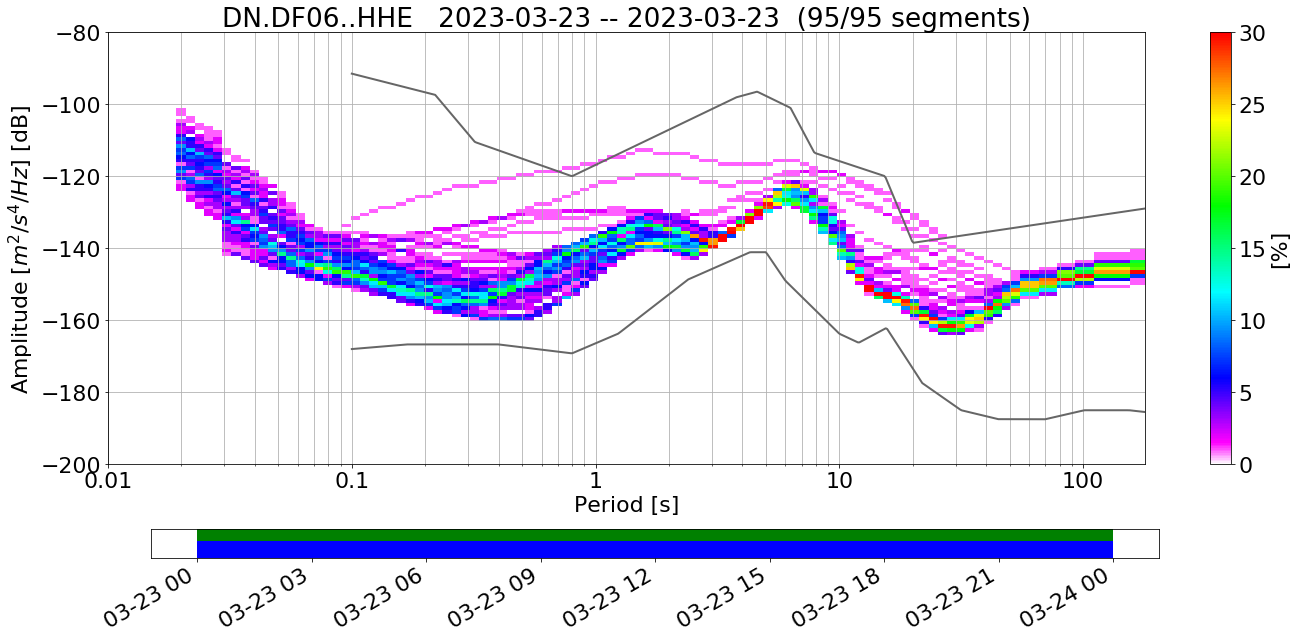

In [29]:
# Parametri za PPSD funkciju
dbrange = (-200,-80,1)
periodrange = None
ppslen = 1800 # 3600

# Učitavanje podataka
st = read(os.path.join(data_folder,"DN.DF06..HHE*"),format='MSEED')
tr = st[0]
        
# Poziv obspy PPSD funkcije
ppsd = PPSD(tr.stats,  metadata=inv_xml, db_bins=dbrange, \
        special_handling=None, period_limits=periodrange, \
        skip_on_gaps=True, ppsd_length=ppslen)

plt.rcParams["figure.figsize"] = (20, 10)
plt.rcParams.update({'font.size': 22})
ppsd.add(st)
ppsd.plot(cmap=pqlx)